C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


                      Metric      Value
0  Mean Absolute Error (MAE)   2.998052
1   Mean Squared Error (MSE)  20.922487
2                   R² Score  -0.324846


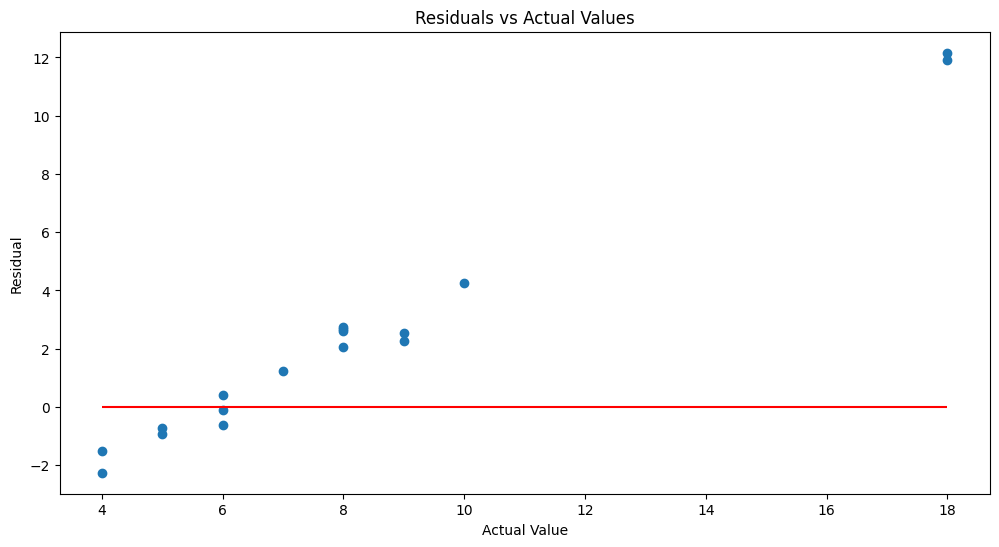

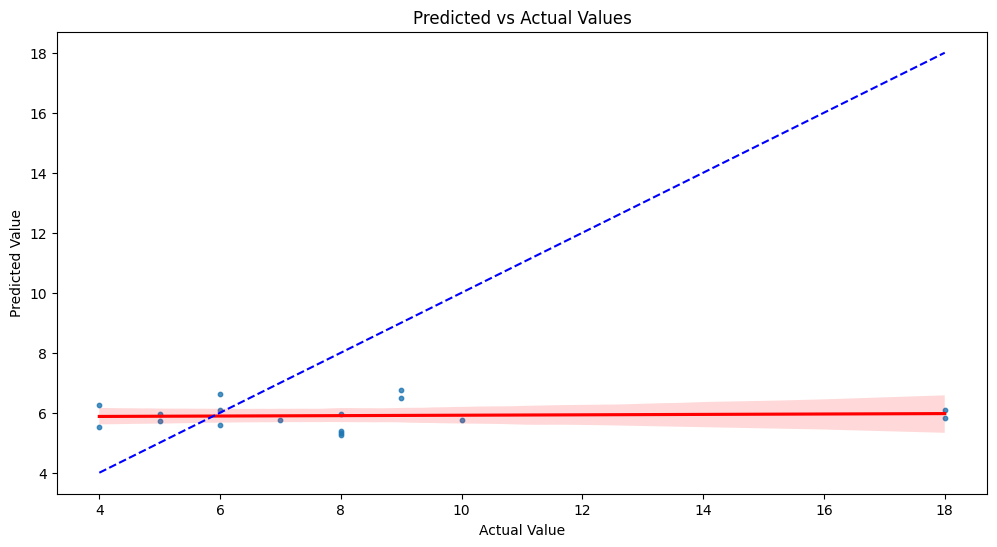

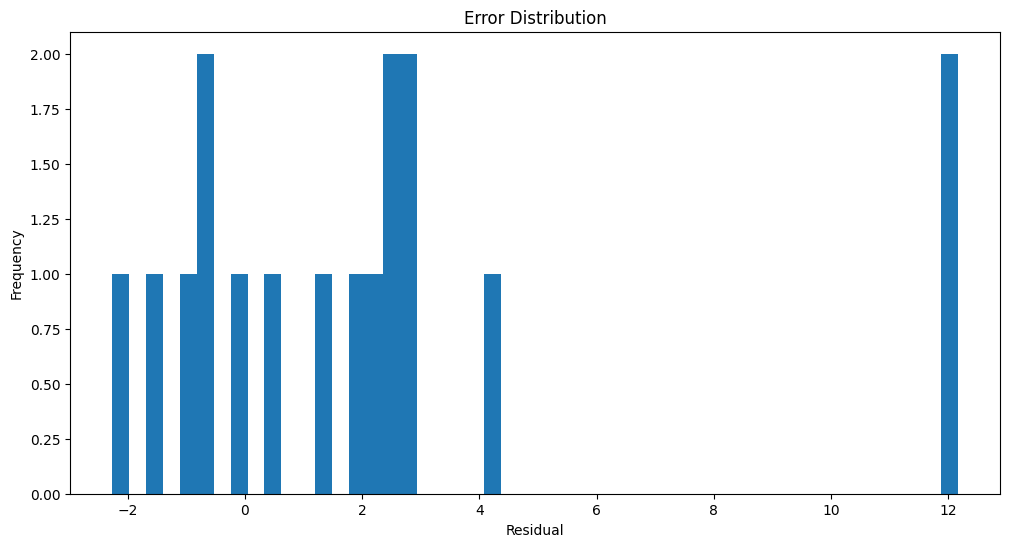

In [1]:
import re
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import signal

# Define constants and parameters
root = '../own_data_test/'
gSampleRate = 7000
upperCutoffFreq = 3000
cutoffFrequencies = [80, upperCutoffFreq]
highPassCoeffs = signal.firwin(401, cutoffFrequencies, fs=gSampleRate, pass_zero="bandpass")

# Load the trained model
model = load_model('update_model.h5')
model.load_weights('update_model.weights.h5')

# Helper functions for preprocessing
def applyHighpass(npArr):
    return signal.lfilter(highPassCoeffs, [1.0], npArr)

def applyLogCompressor(signal, gamma):
    sign = np.sign(signal)
    absSignal = 1 + np.abs(signal) * gamma
    logged = np.log(absSignal)
    scaled = logged * (1 / np.log(1.0 + gamma))
    return sign * scaled

def normalizeVolume(npArr):
    minAmp, maxAmp = np.amin(npArr), np.amax(npArr)
    maxEnv = max(abs(minAmp), abs(maxAmp))
    scale = 1.0 / maxEnv
    npArr *= scale
    return npArr

def load_and_preprocess_file(filepath):
    # Load audio file
    audioBuffer, nativeSampleRate = librosa.load(filepath, dtype=np.float32, mono=True, sr=None)
    
    if nativeSampleRate != gSampleRate:
        # Linear resampling
        duration = len(audioBuffer) / nativeSampleRate
        nTargetSamples = int(duration * gSampleRate)
        timeXSource = np.linspace(0, duration, len(audioBuffer), dtype=np.float32)
        timeX = np.linspace(0, duration, nTargetSamples, dtype=np.float32)
        audioBuffer = np.interp(timeX, timeXSource, audioBuffer)
    
    # Apply preprocessing steps
    audioBuffer = normalizeVolume(applyHighpass(audioBuffer))
    audioBuffer = applyLogCompressor(audioBuffer, 30)
    
    return audioBuffer

def calculated_rr_and_predicted(file_name, root):
    # Extract the respiratory cycle number from the file name
    respiratory_cycle_number = int(re.search(r'\d+', file_name).group())
    rr = respiratory_cycle_number

    # Preprocess audio data
    filepath = f'{root}{file_name}.wav'
    processed_audio = load_and_preprocess_file(filepath)
    
    # Extract features using MFCC (50 features)
    features = np.mean(librosa.feature.mfcc(y=processed_audio, sr=gSampleRate, n_mfcc=50).T, axis=0)

    # Reshape features to match the model's input shape (1, 50, 1)
    features = features.reshape(1, 50, 1)
    
    # Get the prediction
    predicted_value = model.predict(features, verbose=0)[0][0]

    return pd.DataFrame(data=[[file_name, rr, predicted_value]], columns=['patient_id', 'rr', "rr_predicted"])

# Get the list of .wav files
filenames = [s.split('.')[0] for s in os.listdir(path=root) if '.wav' in s]

# Process each file and calculate predictions
i_list = []
for s in filenames:
    i = calculated_rr_and_predicted(s, root)
    i_list.append(i)
recording_info = pd.concat(i_list, axis=0)

# Calculate metrics
mae = mean_absolute_error(recording_info['rr'], recording_info['rr_predicted'])
mse = mean_squared_error(recording_info['rr'], recording_info['rr_predicted'])
r2 = r2_score(recording_info['rr'], recording_info['rr_predicted'])

metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'R² Score'],
    'Value': [mae, mse, r2]
})

# Create directory for plots if it does not exist
if not os.path.isdir("plots_test"):
    os.makedirs('plots_test')

# Display the metrics
print(metrics_df)

# Plotting results
def plot_results(df):
    # Calculate residuals
    residuals = df['rr'] - df['rr_predicted']
    
    # Residuals Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df['rr'], residuals)
    plt.hlines(y=0, xmin=min(df['rr']), xmax=max(df['rr']), colors='r')
    plt.title('Residuals vs Actual Values')
    plt.xlabel('Actual Value')
    plt.ylabel('Residual')
    plt.savefig("plots_test/residuals_vs_actual")
    plt.show()

    # Predicted vs Actual Values with Linear Regression
    plt.figure(figsize=(12, 6))
    sns.regplot(x='rr', y='rr_predicted', data=df, scatter_kws={'s':10}, line_kws={"color": "red"})
    plt.plot([min(df['rr']), max(df['rr'])], [min(df['rr']), max(df['rr'])], color='blue', linestyle='dashed')  # Line of perfect prediction
    plt.title('Predicted vs Actual Values')
    plt.xlabel('Actual Value')
    plt.ylabel('Predicted Value')
    plt.savefig("plots_test/pred_vs_actual")
    plt.show()

    # Error Distribution (Histogram of residuals)
    plt.figure(figsize=(12, 6))
    plt.hist(residuals, bins=50)
    plt.title('Error Distribution')
    plt.xlabel('Residual')
    plt.ylabel('Frequency')
    plt.savefig("plots_test/error_distribution")
    plt.show()

# Call the plotting function
plot_results(recording_info)
